**설치파일**

첫번째 코드를 실행 후 '런타임' 클릭 ->'런타임 다시 시작'을 누른 후 분석을 수행하시면 됩니다.

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install pandas
!pip install JPype1==0.7.0
!pip install gensim==3.8.3
!pip install pyLDAvis==3.2.2
!pip install networkx
!pip3 install konlpy
!pip install transformers
import json
import pandas as pd
import nltk
nltk.download('all')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ast
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim as gensimvis
from konlpy.tag import Okt
from collections import defaultdict
import networkx as nx
import operator
from matplotlib import font_manager as fm
from matplotlib import rc
from tqdm import tqdm
import os
from konlpy.tag import Mecab
from transformers import pipeline
import matplotlib as mpl
import matplotlib.font_manager as fm
from collections import defaultdict, Counter
import itertools


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [ ]:
# CSV 파일 로드
df = pd.read_csv('DCX_Data.csv')

# 불용어 리스트
stopwords = ['ㅋ', 'ㅋㅋ', 'ㅜ', 'ㅠ', '추가 본문', '본문', '신고', '재생', '본문 신고', '재생속도', '이웃추가', '속도', '기본', '설정', '전체', '번지', '그','호', '것', '곳', '수', '공유', '신고', '재생','속도', '사용','안함', '이웃', '추가', '자동','자막', '있는', '하는', '많은', '그', 'naver', 'NAVER','URL', '제', '저', '이', '그리고', '그런데', '하지만', '갑자기', '어떤', '어떻게', '언제', '무엇', '어떻다', '이렇게', '저렇게', '그렇게', '그렇다', '합니다', 'URL', '복사', '이웃','추가', '이웃추가', '본문', '기타', '기능', '공유하기','공유', '신고', '신고하기', '더보기', 'NAVER', 'Crop', 'OpenStreetMap', '지도보기', '상세보기', '지도', '데이터x', '톡톡','2:04URL 복사 이웃추가본문 기타 기능 공유하기 신고하기']

# 리뷰를 문장 단위로 나눠주는 함수
def split_sentences(review):
    return review.split('.')

# 불용어를 제거하고 토큰화하는 함수
def tokenize_and_remove_stopwords(sentence):
    tokens = okt.morphs(sentence)
    tokens = [word for word in tokens if word not in stopwords]
    return tokens

# 키워드별로 문장을 필터링해주는 함수
def filter_sentences(sentences, keywords):
    filtered_sentences = []
    for sentence in sentences:
        if any(keyword in sentence for keyword in keywords):
            filtered_sentences.append(tokenize_and_remove_stopwords(sentence))
    return filtered_sentences

# Okt 객체 생성
okt = Okt()

# 세부 키워드 설정
keywords = {
    '음식': ['음식', '메뉴', '품목', '식재료', '수프', '샐러드', '떡볶이', '커피', '타르트', '브런치', '연어', '세트',  '양이', '맛', '느끼', '달다', '짜다', '신맛', '단맛', '짠맛', '매콤', '매운', '아삭', '부드러운', '탱글'],
    '서비스': ['서비스', '응대', '서빙', '매너', '친절', '불친절', '응답'],
    '분위기': ['분위기', '인테리어', '디자인', '조명', '배경음악', '뷰', '경치', '소리', '시끄러운', '조용한', '감성', '예쁜', '내부', '느낌'],
    '가격': ['가격', '가성비', '싸다', '비싸다', '저렴', '고가', '할인', '특가', '세일', '값'],
    '위치': ['작은', '자리', '좁다', '넓다', '테이블', '의자', '소파', '불편', '편안', '위치', '협소', '만석', '웨이팅', '주차', '공간', '주차장'],
    '친절': ['친절', '불친절', '매너', '응대', '서비스'],
    '청결': ['위생', '깨끗', '청결', '먼지', '더러운', '흠집', '오염', '바닥', '화장실', '주방']
}

# 리뷰를 문장 단위로 분리
df['review_sentences'] = df['review'].apply(split_sentences)

# 토큰화 및 불용어 제거 후 Tokens 컬럼에 저장
df['Tokens'] = df['review'].apply(tokenize_and_remove_stopwords)

# 키워드별로 문장 필터링
for keyword, values in keywords.items():
    df[keyword] = df['review_sentences'].apply(lambda x: filter_sentences(x, values))

# 결과 확인
print(df.head())
df.to_excel('키워드 분류 결과.xlsx')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


           name                                             link  \
0  키쉬미뇽 해운대 미포점    https://blog.naver.com/jetjung74/222274996208   
1  키쉬미뇽 해운대 미포점    https://blog.naver.com/0s0s0s0s1/223070040268   
2  키쉬미뇽 해운대 미포점    https://blog.naver.com/vview0702/222945460688   
3  키쉬미뇽 해운대 미포점   https://blog.naver.com/minji_kkkk/223039453374   
4  키쉬미뇽 해운대 미포점  https://blog.naver.com/glqgkqdms23/222842232928   

                                              review  \
0  카페투어블루라인파크 안에 있는 해운대 디저트 카페 키쉬미뇽 jetjung74 202...   
1  ❤️여행 :)💙 엄마랑 1박2일 부산여행 서니 2023. 4. 10. 12:04UR...   
2  카페vview[해운대]해변열차 해운대 미포 정거장 맛난 카페 카페미뇽(cafe mi...   
3  경상도깨소그밍부산 스카이캡슐 해변열차 코스 해운대블루라인파크 정거장 깨소그밍 202...   
4  Travel.해운대 카페 열차타고 먹고 가기 좋은 키쉬미뇽 해운대 미포점 프로N잡러...   

                                                  음식  \
0  [[타르트, 를, 전문, 으로, 으로, 유기농, 아이스크림, 도, 판매, 하고, 입...   
1  [[12:04, 하기, 하기, 엄마, 랑, 다녀올, 국내, 여행지, 를, 찾아보다가...   
2  [[카페, vview, [, 해운대, ], 해변, 열차, 해운대, 미, 포, 정거장...   
3  [[13:43, 하기, 하기, 안녕하세요, 깨소,

In [ ]:
# CSV 파일 로드
df = pd.read_csv('DCX_Data.csv')

# 불용어 리스트
stopwords = [추가 본문', '본문', '신고', '재생', '본문 신고', '재생속도', '이웃추가', '속도', '기본', '설정', '전체', '번지', '그','호', '것', '곳', '수', '공유', '신고', '재생','속도', '사용','안함', '이웃', '추가', '자동','자막', '있는', '하는', '많은', '그', 'naver', 'NAVER','URL', '제', '저', '이', '그리고', '그런데', '하지만', '갑자기', '어떤', '어떻게', '언제', '무엇', '어떻다', '이렇게', '저렇게', '그렇게', '그렇다', '합니다', 'URL', '복사', '이웃','추가', '이웃추가', '본문', '기타', '기능', '공유하기','공유', '신고', '신고하기', '더보기', 'NAVER', 'Crop', 'OpenStreetMap', '지도보기', '상세보기', '지도', '데이터x', '톡톡','URL 복사 이웃추가본문 기타 기능 공유하기 신고하기']

# 리뷰를 문장 단위로 나눠주는 함수
def split_sentences(review):
    return review.split('.')

# 불용어를 제거하고 토큰화하는 함수
def tokenize_and_remove_stopwords(sentence):
    tokens = mecab.morphs(sentence)
    tokens = [word for word in tokens if word not in stopwords]
    return tokens

# 키워드별로 문장을 필터링해주는 함수
def filter_sentences(sentences, keywords):
    filtered_sentences = []
    for sentence in sentences:
        if any(keyword in sentence for keyword in keywords):
            filtered_sentences.append(tokenize_and_remove_stopwords(sentence))
    return filtered_sentences

# Mecab 객체 생성
mecab = Mecab()

# 세부 키워드 설정
keywords = {
    '음식': ['음식', '메뉴', '품목', '식재료', '수프', '샐러드', '떡볶이', '커피', '타르트', '브런치', '연어', '세트',  '양이', '맛', '느끼', '달다', '짜다', '신맛', '단맛', '짠맛', '매콤', '매운', '아삭', '부드러운', '탱글'],
    '서비스': ['서비스', '응대', '서빙', '매너', '친절', '불친절', '응답'],
    '분위기': ['분위기', '인테리어', '디자인', '조명', '배경음악', '뷰', '경치', '소리', '시끄러운', '조용한', '감성', '예쁜', '내부', '느낌'],
    '가격': ['가격', '가성비', '싸다', '비싸다', '저렴', '고가', '할인', '특가', '세일', '값'],
    '위치': ['작은', '자리', '좁다', '넓다', '테이블', '의자', '소파', '불편', '편안', '위치', '협소', '만석', '웨이팅', '주차', '공간', '주차장'],
    '친절': ['친절', '불친절', '매너', '응대', '서비스'],
    '청결': ['위생', '깨끗', '청결', '먼지', '더러운', '흠집', '오염', '바닥', '화장실', '주방']
}

# 리뷰를 문장 단위로 분리
df['review_sentences'] = df['review'].apply(split_sentences)

# 토큰화 및 불용어 제거 후 Tokens 컬럼에 저장
df['Tokens'] = df['review'].apply(tokenize_and_remove_stopwords)

# 키워드별로 문장 필터링
for keyword, values in keywords.items():
    df[keyword] = df['review_sentences'].apply(lambda x: filter_sentences(x, values))

# 결과 확인
print(df.head())
df.to_excel('키워드 분류 결과.xlsx')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Exception: ignored

# **Word Cloud**
(위에서부터 음식, 맛, 서비스, 가격, 자리, 분위기, 친절, 위생, 전체 키워드 Word Cloud)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


가게명을 입력해주세요: 수프올샐러드


/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54532

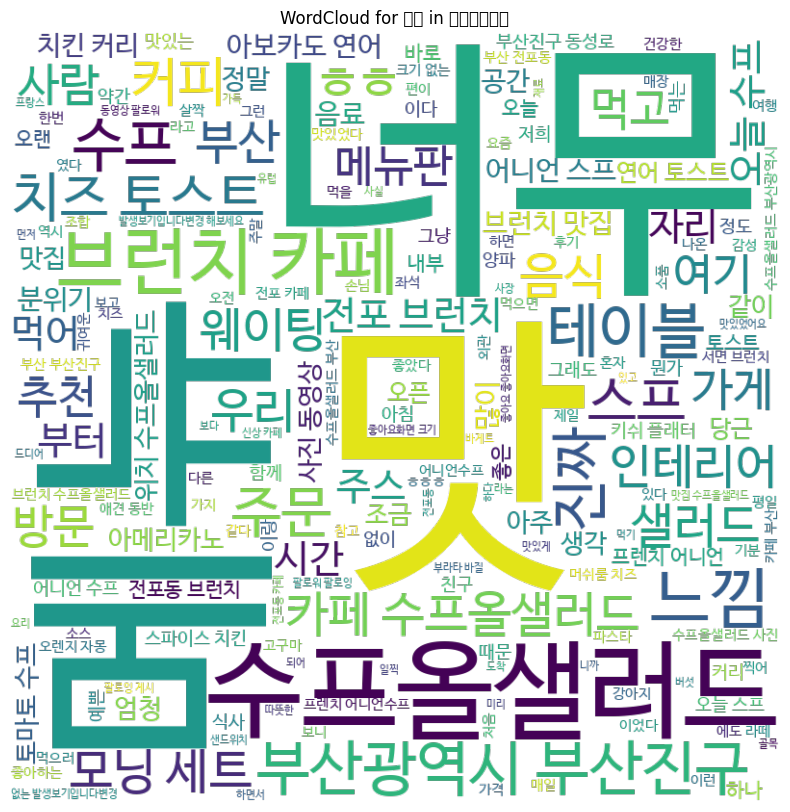

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47579 (\N{HANGUL SYLLABLE MAS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


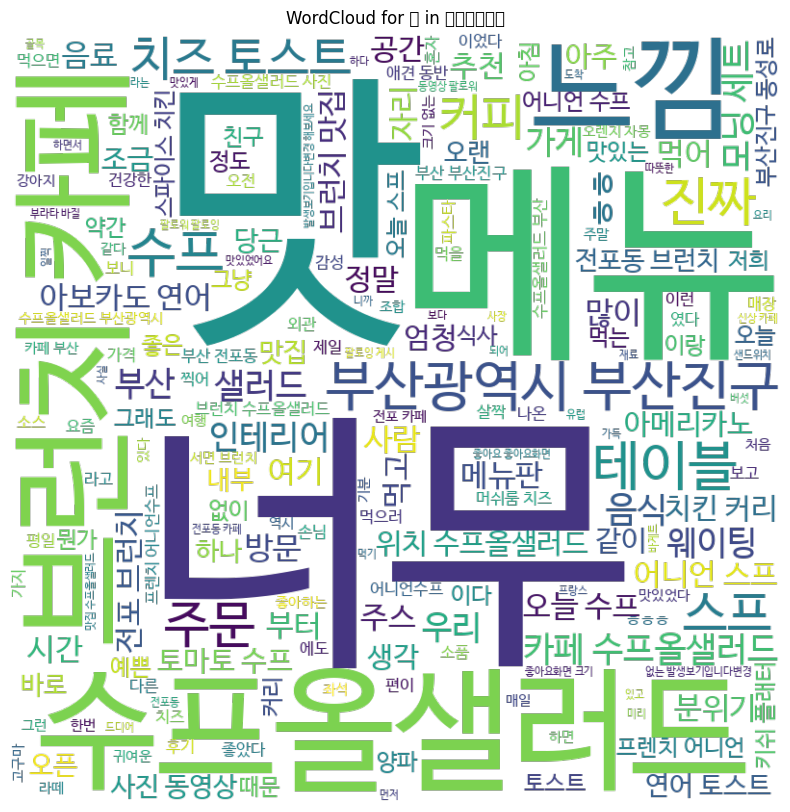

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


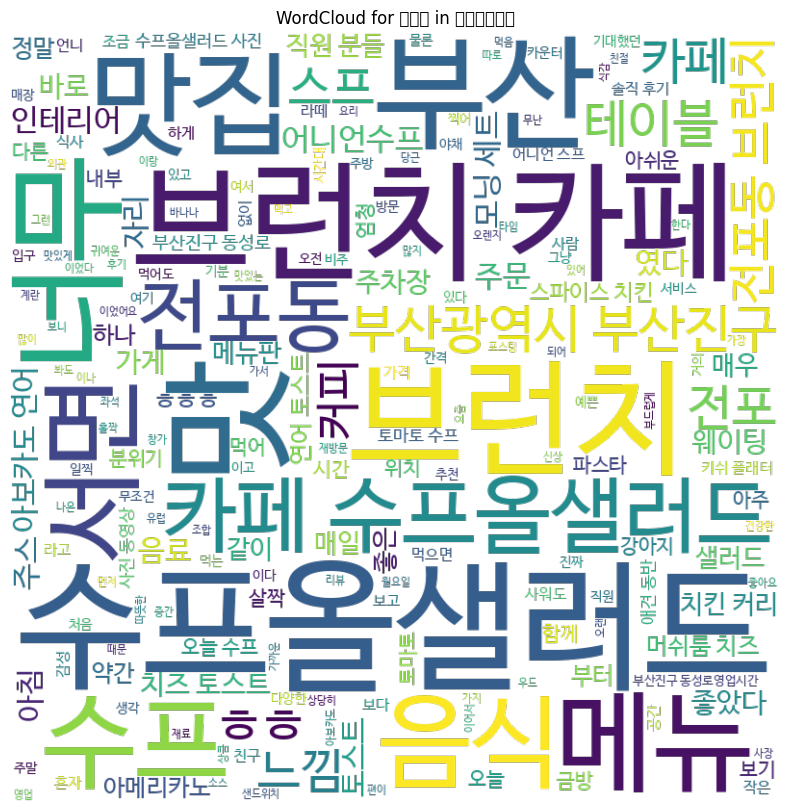

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


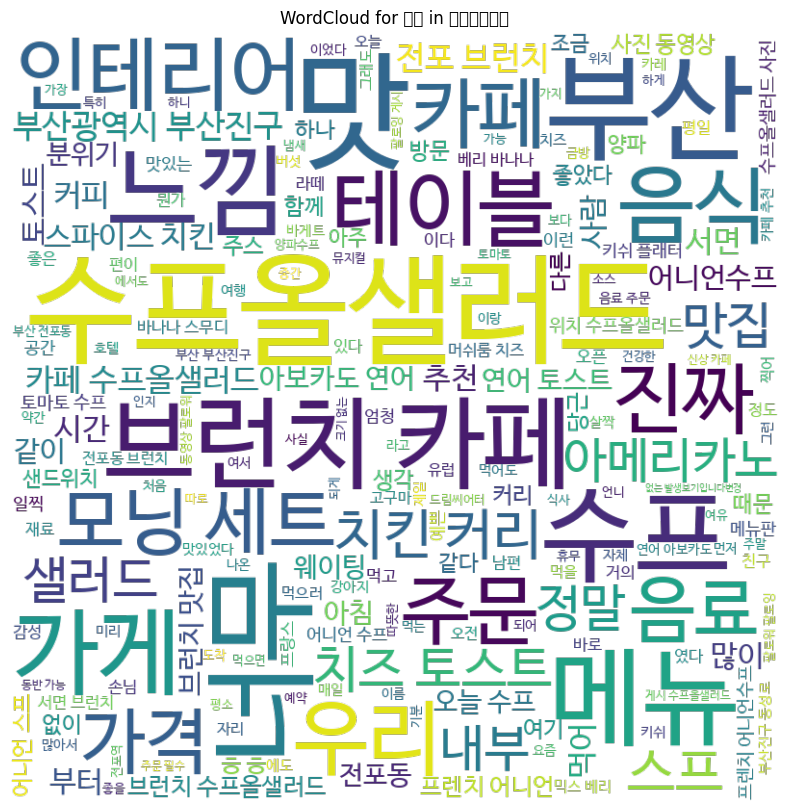

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


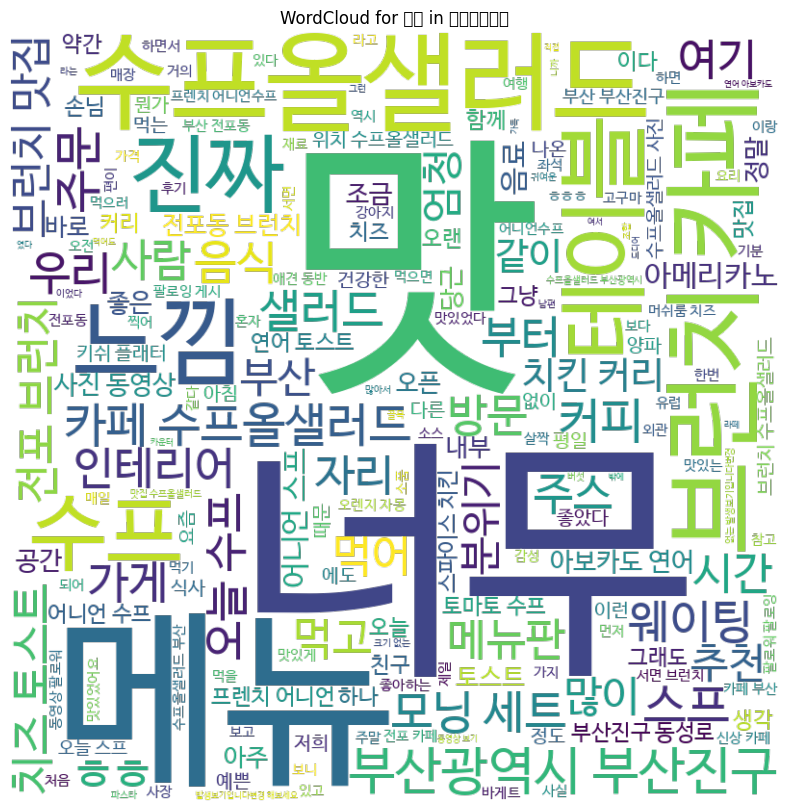

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


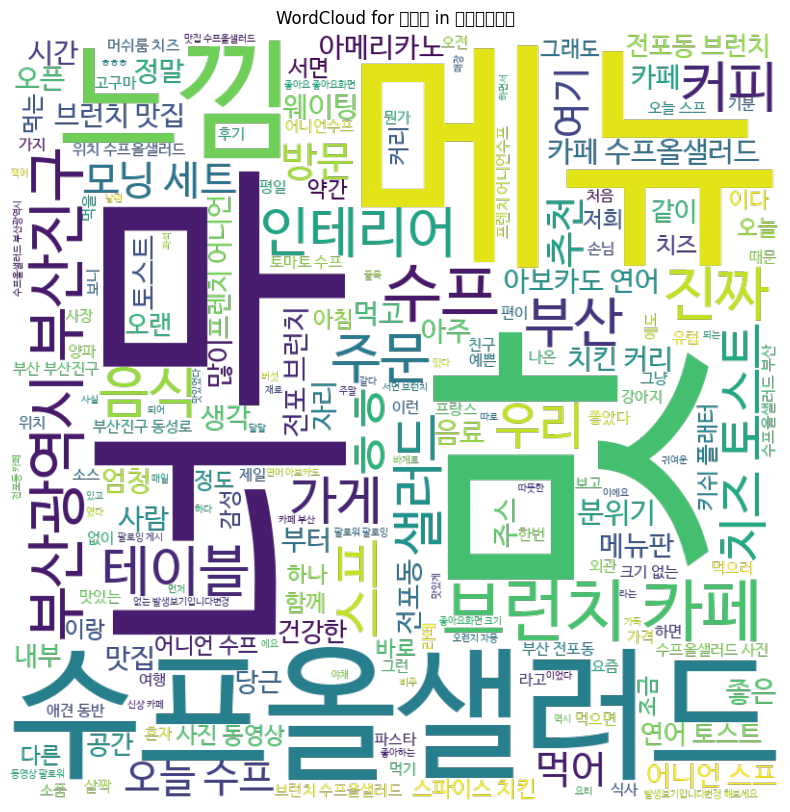

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52828 (\N{HANGUL SYLLABLE CIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51208 (\N{HANGUL SYLLABLE JEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


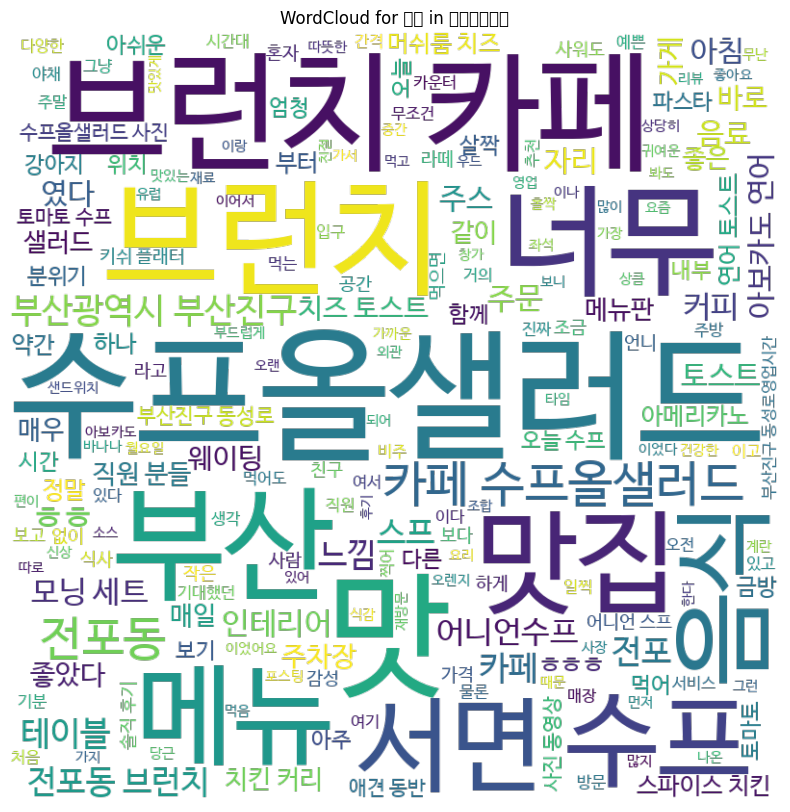

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


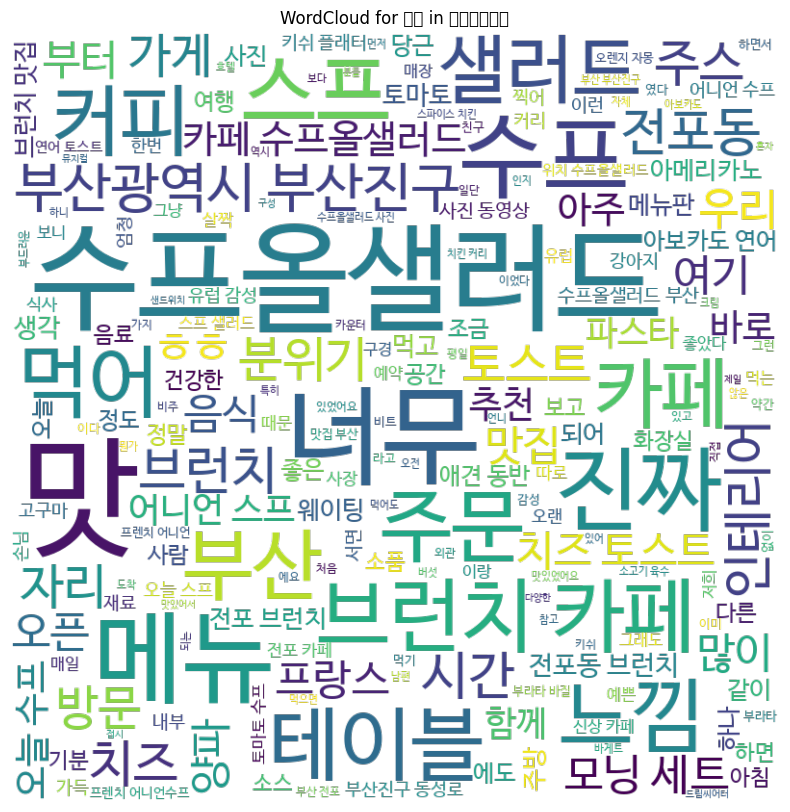

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


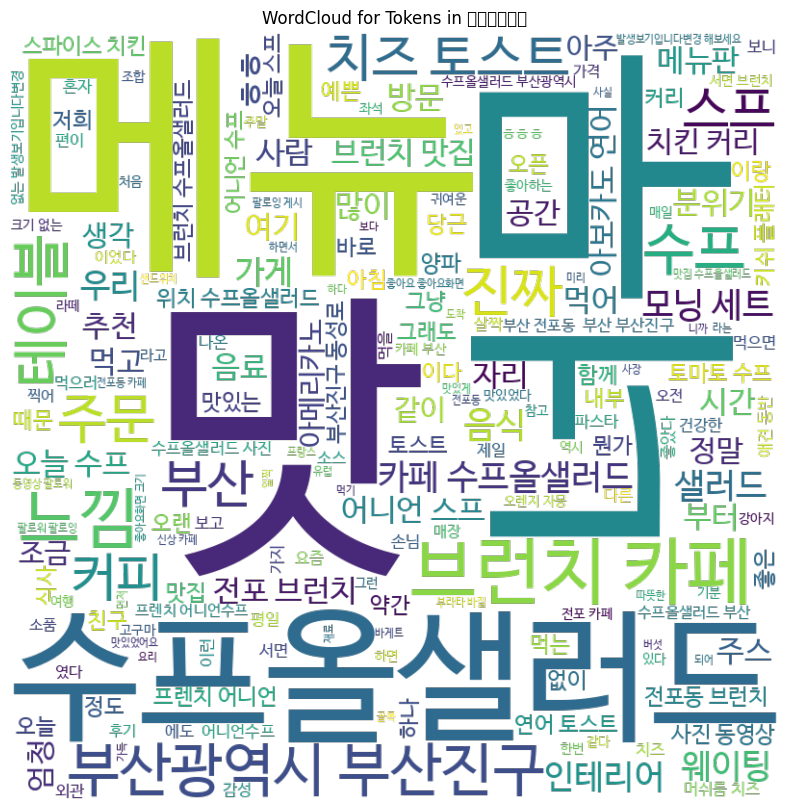

위에서부터 음식, 맛, 서비스, 가격, 자리, 분위기, 친절, 위생, 전체 키워드 Word Cloud


In [ ]:
# Load dataframe (replace with your actual data)
df = pd.read_csv('DCX_Data.csv', low_memory = False)

# 가게명 입력받기
store_name = input("가게명을 입력해주세요: ")

# 입력받은 가게명에 해당하는 데이터만 선택
df_store = df[df['name'] == store_name]

# 한글 폰트 경로 지정
font_path = 'NanumBarunGothic.ttf'

# 각 컬럼에 대한 워드클라우드 생성 및 출력
for column in ['음식', '서비스', '분위기', '가격', '위치', '친절', '청결', 'Tokens']:
    text = ' '.join(df_store[column].dropna().map(str))  # NaN 값을 제거하고 모든 값을 문자열로 변환
    if text.strip():  # Check if text is not empty
        wordcloud = WordCloud(font_path=font_path, mode='RGBA', background_color=None, width=800, height=800).generate(text)
        plt.figure(figsize=(10, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'WordCloud for {column} in {store_name}')
        plt.show()
    else:
        print(f"No words to generate WordCloud for {column} in {store_name}")
print("위에서부터 음식, 서비스, 분위기, 가격, 위치, 친절, 청결, 전체 키워드 Word Cloud")

# **LDA 토픽모델링**
토픽모델링 결과(csv, html은 좌측에 생성되어 있습니다.
다운로드해서 사용하세요)

In [ ]:
# 데이터를 로드합니다.
df = pd.read_csv('/content/DCX_Data.csv', low_memory=False)

# 사용자로부터 가게명을 입력 받습니다.
restaurant_name = input("가게명을 입력하세요: ")

# 해당 가게명에 대한 행만 선택합니다.
df_restaurant = df[df['name'] == restaurant_name]

# 'Tokens' 컬럼의 값이 NaN이라면 빈 문자열로 대체합니다.
df_restaurant['Tokens'] = df_restaurant['Tokens'].apply(lambda x: x if pd.notnull(x) else '')

# 이제 토큰화를 진행합니다.
df_restaurant['Tokens'] = df_restaurant['Tokens'].apply(lambda x: x.split())

# 문서-단어 행렬을 생성합니다.
dictionary = corpora.Dictionary(df_restaurant['Tokens'])
corpus = [dictionary.doc2bow(text) for text in df_restaurant['Tokens']]

# LDA 모델을 훈련합니다.
num_topics = 10  # 원하는 토픽의 수를 설정
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# 각 문서의 토픽 분포를 저장합니다.
df_restaurant['Topic_Distribution'] = df_restaurant['Tokens'].apply(lambda x: lda_model[dictionary.doc2bow(x)])

# pyLDAvis를 이용해 토픽 모델링 결과를 시각화합니다.
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis_data, f'{restaurant_name}_lda.html')

# 각 토픽의 단어 분포와 함께 저장합니다.
topic_word_distribution = [lda_model.show_topic(i) for i in range(num_topics)]
for i in range(num_topics):
    topic_words = [word for word, _ in topic_word_distribution[i]]
    df_restaurant[f'Topic_{i}_Words'] = pd.Series(topic_words)

# 결과를 저장합니다.
df_restaurant.to_csv(f'{restaurant_name}_토픽모델링_결과.csv', index=False)

# 결과 출력
for i in range(num_topics):
    print(f"Topic {i}'s word distribution: {topic_word_distribution[i]}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


가게명을 입력하세요: 수프올샐러드


<ipython-input-3-60691c133dab>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurant['Tokens'] = df_restaurant['Tokens'].apply(lambda x: x if pd.notnull(x) else '')
<ipython-input-3-60691c133dab>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurant['Tokens'] = df_restaurant['Tokens'].apply(lambda x: x.split())
<ipython-input-3-60691c133dab>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Topic 0's word distribution: [('카페', 0.007676535), ('수프올샐러드', 0.0066891043), ('스프', 0.0064121387), ('맛', 0.006325134), ('너무', 0.005688377), ('치즈', 0.0048464863), ('토스트', 0.0046861353), ('부산진구', 0.0042850114), ('부산', 0.004198157), ('브런치', 0.0039264713)]
Topic 1's word distribution: [('수프', 0.00017658994), ('맛', 0.00016444658), ('카페', 0.00015677899), ('수프올샐러드', 0.00015455585), ('토스트', 0.00015428902), ('브런치', 0.00015079111), ('치즈', 0.00015015357), ('부산', 0.00014552978), ('메뉴', 0.00014543417), ('스프', 0.0001440305)]
Topic 2's word distribution: [('너무', 0.0066829817), ('맛', 0.00608412), ('수프올샐러드', 0.0057904427), ('연어', 0.0054491158), ('사진', 0.0044868696), ('수프', 0.004400544), ('부산', 0.004082235), ('먹고', 0.0040094107), ('부산광역시', 0.0039196084), ('시간', 0.003411532)]
Topic 3's word distribution: [('수프올샐러드', 0.019988522), ('브런치', 0.0151988845), ('카페', 0.014751566), ('부산', 0.0111607), ('스프', 0.010221134), ('토스트', 0.009232037), ('수프', 0.008713746), ('너무', 0.0068557435), ('맛', 0.0061910753), ('부산진구'

<ipython-input-3-60691c133dab>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurant[f'Topic_{i}_Words'] = pd.Series(topic_words)
<ipython-input-3-60691c133dab>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurant[f'Topic_{i}_Words'] = pd.Series(topic_words)
<ipython-input-3-60691c133dab>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

# **네트워크 분석**
min_freq를 조절하여 네트워크 분석의 노드(가지) 수를 조절.

삼미분식: 약 15

키쉬미뇽 해운대 미포점: 약40

수프올샐러드: 약 100

카페 그라운드: 약 70

출력결과를 늘리고 싶으면 숫자를 낮추고,
줄이고 싶으면 숫자를 높이면 됩니다.

가게 이름을 입력하세요: 카페 그라운드


<ipython-input-1-c0aecb972970>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_df['Filtered_Nouns'] = store_df['Nouns'].apply(lambda nouns: [word for word in nouns if word_freq[word] >= min_freq])


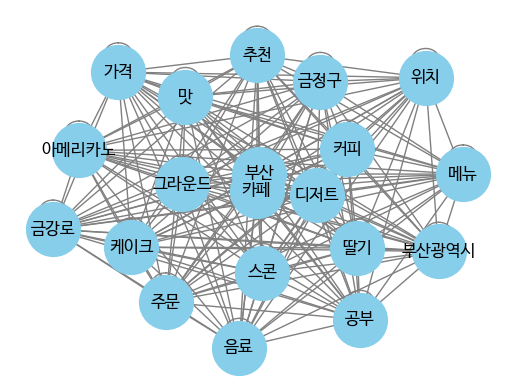

In [ ]:
# 한글 폰트 경로 설정
font_path = 'NanumBarunGothic.ttf'  # 또는 시스템에 설치된 다른 한글 폰트 경로로 변경해보세요

# 폰트 설정
font_name = fm.FontProperties(fname=font_path).get_name()

# matplotlib의 폰트 설정
plt.rc('font', family=font_name)


# 데이터프레임 로드 (실제 데이터로 교체)
df = pd.read_csv('DCX_Data.csv', low_memory=False)

# 문자열 형태의 리스트를 실제 리스트로 변환
df['Nouns'] = df['Nouns'].apply(lambda x: x.split())

# 사용자에게 가게 이름 입력받기
store_name = input("가게 이름을 입력하세요: ")

# 가게 이름으로 데이터프레임 필터링
store_df = df[df['name'] == store_name]

# 단어 빈도 계산
word_freq = Counter(itertools.chain(*store_df['Nouns']))

# 빈도 임계값 설정
min_freq = 80 #@param {type:"string"} # 이 값을 늘려서 노드의 수를 줄일 수 있습니다

# 빈도를 기반으로 리뷰의 명사 필터링
store_df['Filtered_Nouns'] = store_df['Nouns'].apply(lambda nouns: [word for word in nouns if word_freq[word] >= min_freq])

# 단어의 공동 출현 빈도 계산
co_occurrence = defaultdict(int)
for nouns in store_df['Filtered_Nouns']:
    for pair in itertools.combinations(nouns, 2):  # 모든 조합의 쌍을 가져옵니다
        co_occurrence[tuple(sorted(pair))] += 1  # 카운트 증가

# 그래프 생성
G = nx.Graph()

for pair, freq in co_occurrence.items():
    word1, word2 = pair
    G.add_edge(word1, word2, weight=freq)

# 가중치가 임계값보다 작은 엣지를 제거 (선택사항)
threshold = 0  # 이 값을 늘려서 노드의 수를 줄일 수 있습니다
for edge in list(G.edges()):
    if G.get_edge_data(*edge)['weight'] < threshold:
        G.remove_edge(*edge)

# 독립된 노드 (엣지가 없는) 제거
G.remove_nodes_from(list(nx.isolates(G)))

# 네트워크 그리기
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1500)
nx.draw_networkx_edges(G, pos, edge_color='grey')
nx.draw_networkx_labels(G, pos, font_size=12, font_family=font_name)

plt.axis('off')
plt.show()



# **감성분석**

In [ ]:
# Initialize the sentiment analysis model
classifier = pipeline("sentiment-analysis", model="matthewburke/korean_sentiment")

df = pd.read_csv('/content/DCX_Data.csv')

#키워드를 네이버키워드로 변경하는것이 좋을듯하오
keywords_map = {
    '음식': ['음식', '메뉴', '품목', '식재료', '수프', '샐러드', '떡볶이', '커피', '타르트', '브런치', '연어', '세트',  '양이'],
    '맛': ['맛', '느끼', '달다', '짜다', '신맛', '단맛', '짠맛', '매콤', '매운', '아삭', '부드러운', '탱글'],
    '서비스': ['서비스', '응대', '서빙', '매너', '친절', '불친절', '응답'],
    '가격': ['가격', '가성비', '싸다', '비싸다', '저렴', '고가', '할인', '특가', '세일', '값'],
    '자리': ['작은', '자리', '좁다', '넓다', '테이블', '의자', '소파', '불편', '편안', '위치', '협소', '만석', '웨이팅', '공부', '카공', '주차', '공간', '주차장'],
    '분위기': ['분위기', '인테리어', '디자인', '조명', '배경음악', '뷰', '경치', '소리', '시끄러운', '조용한', '감성', '예쁜', '내부', '느낌'],
    '친절': ['친절', '불친절', '매너', '응대', '서비스'],
    '위생': ['위생', '깨끗', '청결', '먼지', '더러운', '흠집', '오염', '바닥', '화장실', '주방']
}

# Add new columns
for keyword in keywords_map:
    df[keyword] = 0.0

# Define a function to get the sentiment
def get_sentiment(text):
    preds = classifier(text)
    return preds[0]['score'] if preds[0]['label'] == 'LABEL_1' else 1 - preds[0]['score']

store_name = input("가게명을 입력하세요: ")

if store_name in df['name'].values:
    total_sentiments = []
    for keyword, related_words in keywords_map.items():
        sentences = nltk.tokenize.sent_tokenize(df[df['name'] == store_name]['clean_text'].values[0])
        sentences = [sentence for sentence in sentences if any(word in sentence for word in related_words)]
        sentiments = [get_sentiment(sentence) for sentence in sentences]
        total_sentiments.extend(sentiments)
        avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
        df.loc[df['name'] == store_name, keyword] = avg_sentiment

    overall_sentiment = sum(total_sentiments) / len(total_sentiments) if total_sentiments else 0

    file_name = store_name + "_감성분석_결과.csv"
    df.to_csv(file_name, index=False)

    print("Sentiment scores of {}: ".format(store_name))
    for keyword in keywords_map:
        score = df[df['name'] == store_name][keyword].values[0]
        print("{}: {:.2f}점".format(keyword, score * 100))
    print("통합감성 점수: {:.2f}점".format(overall_sentiment * 100))
else:
    print("The store name does not exist in the dataframe.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


가게명을 입력하세요: 카페 그라운드
Sentiment scores of 카페 그라운드: 
음식: 93.50점
맛: 70.60점
서비스: 96.47점
가격: 87.88점
자리: 92.70점
분위기: 69.56점
친절: 96.47점
위생: 96.78점
통합감성 점수: 83.10점
